# Phase Retrieval Tutorial

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://githubtocolab.com/ophusgroup/apmc2025-4dstem-workshop/blob/main/notebooks/try-it-yourself/11.phase_retrieval_01.ipynb)

In this tutorial notebook, we will reconstruct a phase contrast image from gold nanoparticles on a carbon support. We will use differential phase contrast (DPC), parallax depth sectioning (also known as S-matrix reconstruction, or tilt-corrected bright field imaging) and ptychography. In this dataset, the probe is defocused which provides a good imaging condition for both parallax and ptychography, but poorer image quality for virtual dark field and bright field imaging, and DPC.

### Downloads

* [4D-STEM dataset](https://drive.google.com/file/d/1UYIdz95MEM3Va-WCY1AIfPVve1A-2-kB/view?usp=share_link)
* [vacuum probe intensity](https://drive.google.com/file/d/16hq03fZ3YZKapDG90WV1MJgBa_qcJsOQ/view?usp=share_link)

### Acknowledgements

This tutorial was created by the py4DSTEM instructor team:
- Stephanie Ribet (sribet@lbl.gov)
- Georgios Varnavides (gvarnavides@berkeley.edu)
- Colin Ophus (clophus@lbl.gov)

The 4D-STEM dataset used here was recorded by Stephanie Ribet on the TEAM I microscope, at the National Center for Electron Microscopy, a part of the Molecular Foundry DOE User Facility.

Updated Feb 01, 2025

In [1]:
%pip install py4DSTEM > /dev/null 2>&1

In [2]:
import numpy as np
import py4DSTEM
print(py4DSTEM.__version__)
%matplotlib inline

cupyx.jit.rawkernel is experimental. The interface can change in the future.


0.14.18


In [3]:
# Get the 4DSTEM data
py4DSTEM.io.gdrive_download(
    id_ = 'https://drive.google.com/uc?id=1UYIdz95MEM3Va-WCY1AIfPVve1A-2-kB',
    destination = '/content/',
    filename = 'ptycho_gold_data_2024.h5',
    overwrite=True
)

# Get the probe
py4DSTEM.io.gdrive_download(
    id_ = 'https://drive.google.com/uc?id=16hq03fZ3YZKapDG90WV1MJgBa_qcJsOQ',
    destination = '/content/',
    filename = 'ptycho_gold_probe_2024.h5',
    overwrite=True
)

Downloading...
From (original): https://drive.google.com/uc?id=1UYIdz95MEM3Va-WCY1AIfPVve1A-2-kB
From (redirected): https://drive.google.com/uc?id=1UYIdz95MEM3Va-WCY1AIfPVve1A-2-kB&confirm=t&uuid=a4cbd3c7-ab24-4027-b3dd-6f2eb7b5b93a
To: /content/ptycho_gold_data_2024.h5
100%|██████████| 340M/340M [00:06<00:00, 50.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=16hq03fZ3YZKapDG90WV1MJgBa_qcJsOQ
To: /content/ptycho_gold_probe_2024.h5
100%|██████████| 158k/158k [00:00<00:00, 18.8MB/s]


In [4]:
file_path = '/content/'
file_data = file_path + 'ptycho_gold_data_2024.h5'
file_probe = file_path + 'ptycho_gold_probe_2024.h5'

## Load data, basic visualization

In [5]:
datacube = py4DSTEM.read(file_data)
probe = py4DSTEM.read(file_probe)

We calculate and plot mean diffraction pattern and vacuum probe measurement:

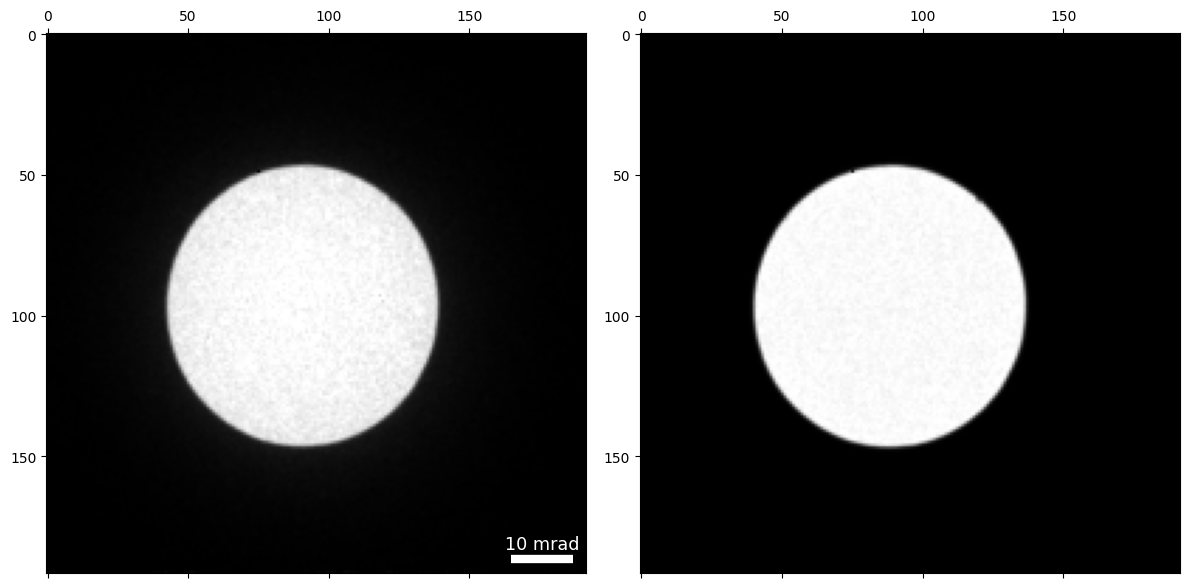

In [6]:
datacube.get_dp_mean();

py4DSTEM.show(
    [
        datacube.tree('dp_mean'),
        probe.data,

    ],
    # cmap = "magma",
)

## Calibration

We estimate the probe radius:

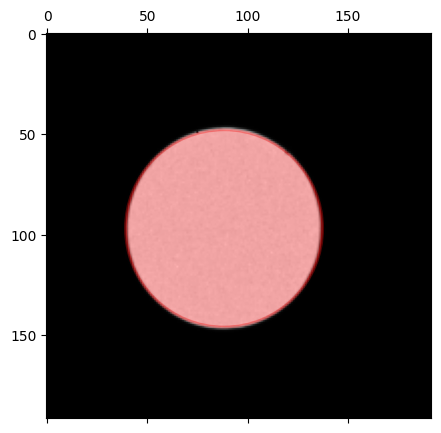

In [7]:
probe_radius_pixels, probe_qx0, probe_qy0 = datacube.get_probe_size(
    probe.data,
    plot = True,
    thresh_upper = 0.7
)

This allows us to manually set the calibrations from known values:
- probe step size of 2.39 Angstroms
- probe convergence semiangle of 22.6 mrads

In [8]:
datacube.calibration.set_R_pixel_size(2.39)
datacube.calibration.set_R_pixel_units('A')
datacube.calibration.set_Q_pixel_size(22.6/ probe_radius_pixels)
datacube.calibration.set_Q_pixel_units('mrad')
datacube.calibration

Calibration( A Metadata instance called 'calibration', containing the following fields:

             Q_pixel_size:      0.4595314492617885
             R_pixel_size:      2.39
             Q_pixel_units:     mrad
             R_pixel_units:     A
             QR_flip:           False
             _root_treepath:    
             probe_semiangle:   49.18052950740506
             qx0_mean:          96.88914881768615
             qy0_mean:          88.25481772529096
)

# Virtual images

Next, we create BF and DF virtual images by using the detected radius

100%|██████████| 2304/2304 [00:00<00:00, 26255.07it/s]


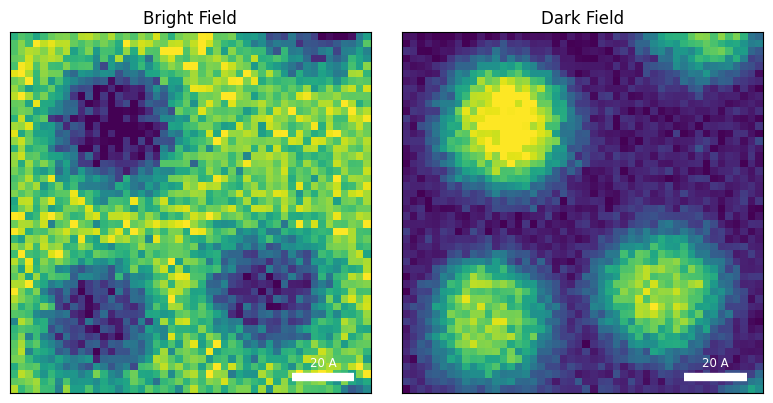

In [9]:
expand_BF = 2.0

center = (probe_qx0, probe_qy0)
radius_BF = probe_radius_pixels + expand_BF
radii_DF = (probe_radius_pixels + expand_BF, 1e3)

datacube.get_virtual_image(
    mode = 'circle',
    geometry = (center,radius_BF),
    name = 'bright_field',
    shift_center = False,
)
datacube.get_virtual_image(
    mode = 'annulus',
    geometry = (center,radii_DF),
    name = 'dark_field',
    shift_center = False,
);

py4DSTEM.show(
    [
        datacube.tree('bright_field'),
        datacube.tree('dark_field'),
    ],
    cmap='viridis',
    ticks = False,
    axsize = (4,4),
    title = ['Bright Field','Dark Field'],
)

We can immediately see the morphology of the sample - three Au nanoparticles sitting on the carbon support.  

In the bright field image, the NPs are dark because more electrons scatter out of the bright field disk when the probe is over one of the NPs. In the dark field image, we measure electrons scattered out of the bright field disk, hence we get higher intensity when the probe is over one of the NPs.

These images are 'complementary' meaning they roughly add to a constant image. The images are "blurry" because the probe has been defocused in this dataset - this produces significant overlap between adjacent probes, which helps the ptychographic reconstruction, but will make the virtual images and DPC reconstructions blurry.



## Differential Phase Contrast (DPC)

In DPC, we measure the center of mass (CoM) of the electron probe in diffraction space for each probe position. This CoM corresponds to the average in-plane momentum of the electron beam, which is proportional to the electic field. In matter, the electric field is the derivative of the sample's electrostatic potential, which in turn is proportional to the sample's phase shift. Hence if we numerically integrate the signal, we can reconstruct the phase.



We first estimate the relative rotation between the real space scanning coordinate system and the diffraction space detector coordinates. This value can be non-zero if the STEM scan coils are rotated to some angle, if the detector is rotated around the optical axis, or if the data has been read incorrectly (transposing x and y or kx and ky for example).

A good recosntruction will show the CoMx has dipoles along the x, while the CoMy has dipoles in the y direction.



We will reconstruct the DPC with a mask to select only the bright field disk to remove spurious signals from diffracted disks that can bias the results in this small field of view.

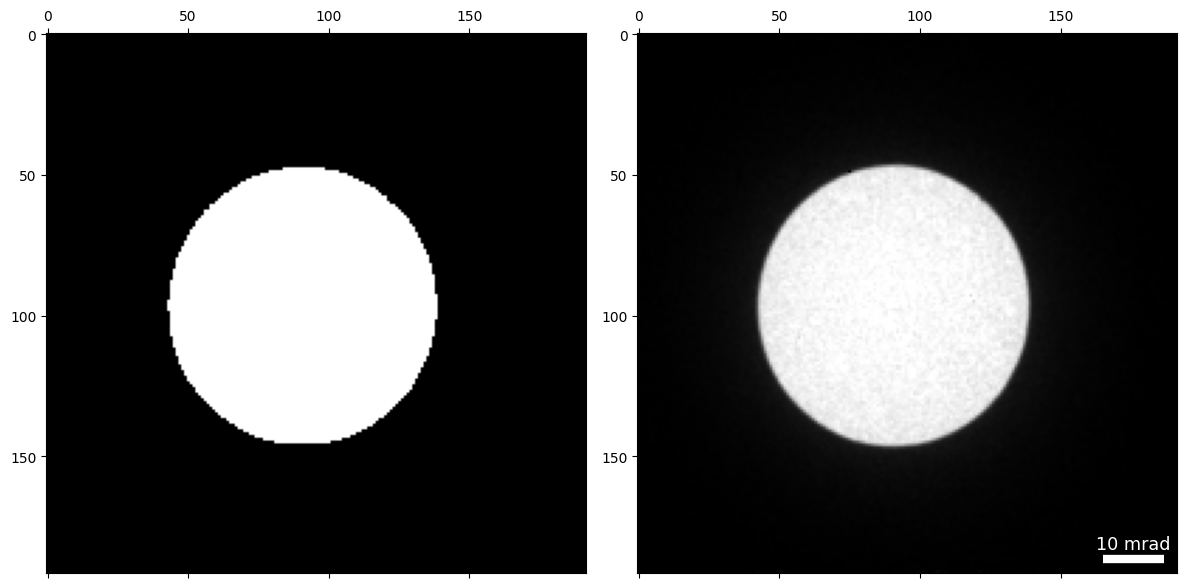

In [10]:
### create mask for bright field disk
dp_mask = datacube.tree('dp_mean').data>0.8
py4DSTEM.show(
    [
        dp_mask,
        datacube.tree('dp_mean'),
    ]
)

Calculating center of mass: 100%|██████████| 2304/2304 [00:00<00:00, 10639.16probe position/s]
Best fit rotation = -15 degrees.


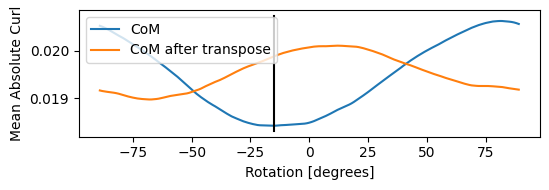

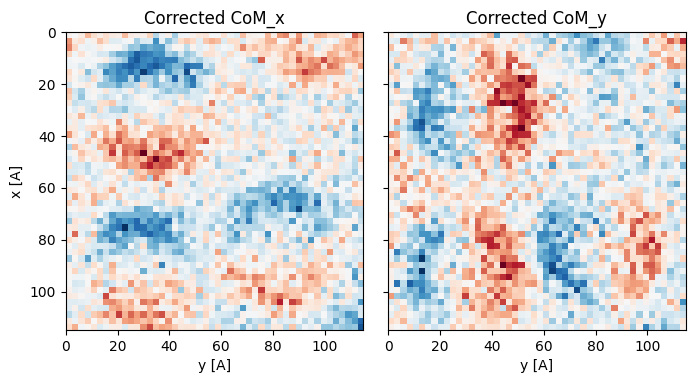

In [11]:
dpc = py4DSTEM.process.phase.DPC(
   datacube = datacube,
   energy = 300e3,
).preprocess(
    dp_mask = dp_mask,
    # force_com_transpose = True
)

Reconstructing phase:  42%|████▏     | 27/64 [00:00<00:00, 1652.19 iter/s]
Step-size has decreased below stopping criterion 1e-06.


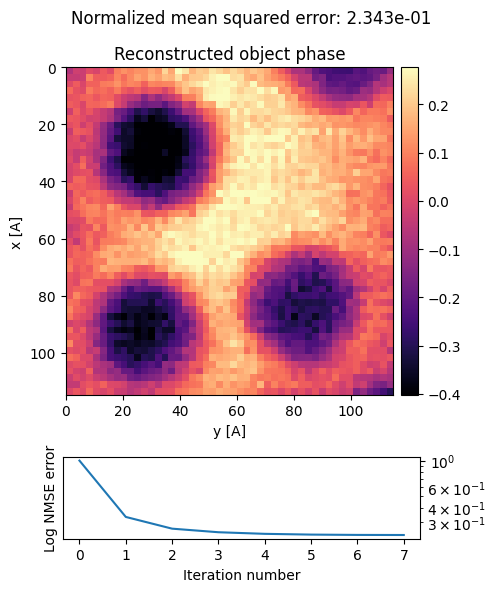

In [12]:
dpc=dpc.reconstruct().visualize()

We see that the particles are very blurry due to the defocused electron probe.  However the signal to noise is much higher, shown by how smooth the outputs are. Phase contrast imaging such as DPC reconstructions are **much** more dose-efficient than bright field or dark field imaging for thin samples.

Note that the phase signal is flipped - the gold nanoparticle phase is lower than the surrounding godld. Because our sample consists of positive ionic cores screened by negative electron orbitals, the sample's electroscatic potential should always be >=0, and therefore the object wave's phase shift should also be positive.

This is an unphysical artifact, which is caused by rotating the diffraction patterns by 180 degrees. Our direction-finding routine above cannot solve for this 180 degree rotation ambiguity - instead it is up to the user to fix it! We can apply this 180 flip in the preprocessing step:

Calculating center of mass: 100%|██████████| 2304/2304 [00:00<00:00, 9962.93probe position/s] 
Best fit rotation forced to 165 degrees.


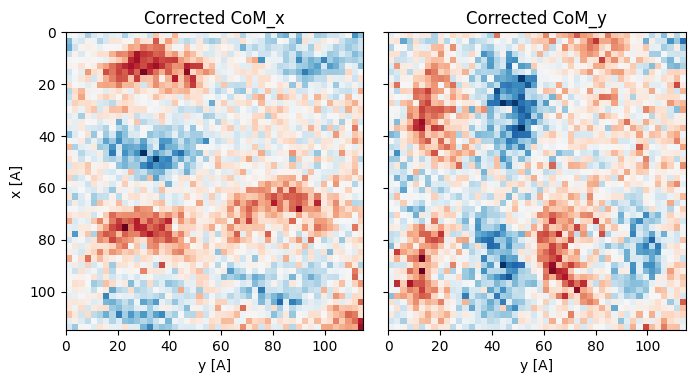

In [13]:
dpc_180 = py4DSTEM.process.phase.DPC(
   datacube = datacube,
   energy = 300e3,
).preprocess(
    dp_mask = dp_mask,
    force_com_rotation=-15 + 180
)

Reconstructing phase:  42%|████▏     | 27/64 [00:00<00:00, 1818.78 iter/s]
Step-size has decreased below stopping criterion 1e-06.


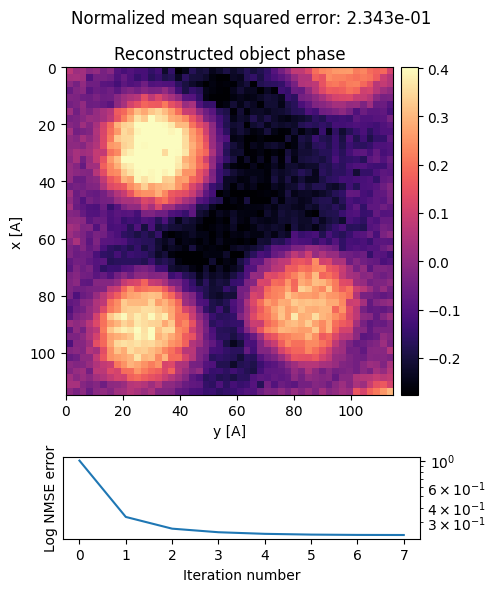

In [14]:
dpc_180 = dpc_180.reconstruct().visualize()

## Parallax Imaging

Each pixel in diffraction space can be used to form a virtual image.  On the bright field disk, each of these pixels represents a plane wave of electrons which impacted the sample at a different angle, and because the probe is defocused, a different position on the sample surface. We can computationally align each of these images by using the "parallax operator." This operator corrects the geometric intercepts of each virtual image to be properly focused by aligning the virtual images. The final step is to correct the defocus either by solving the full complex wave (S-matrix reconstruction) or assuming a weak phase object and using contrast transfer function (CTF)-correction.

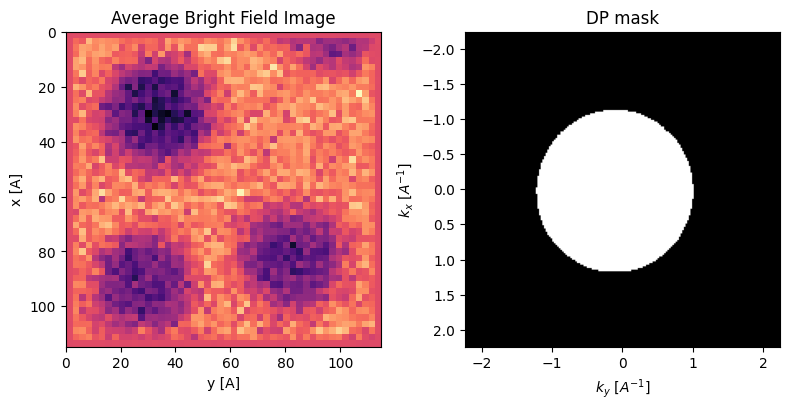

In [15]:
parallax = py4DSTEM.process.phase.Parallax(
    datacube=datacube,
    energy = 300e3,
    device = "gpu",
    verbose = True,
    object_padding_px=(4,4),
).preprocess(
    plot_average_bf=True,
    threshold_intensity=0.6,
    edge_blend=2,
)

Alignment at bin 8: 100%|██████████| 138/138 [00:01<00:00, 115.92 image subsets/s]


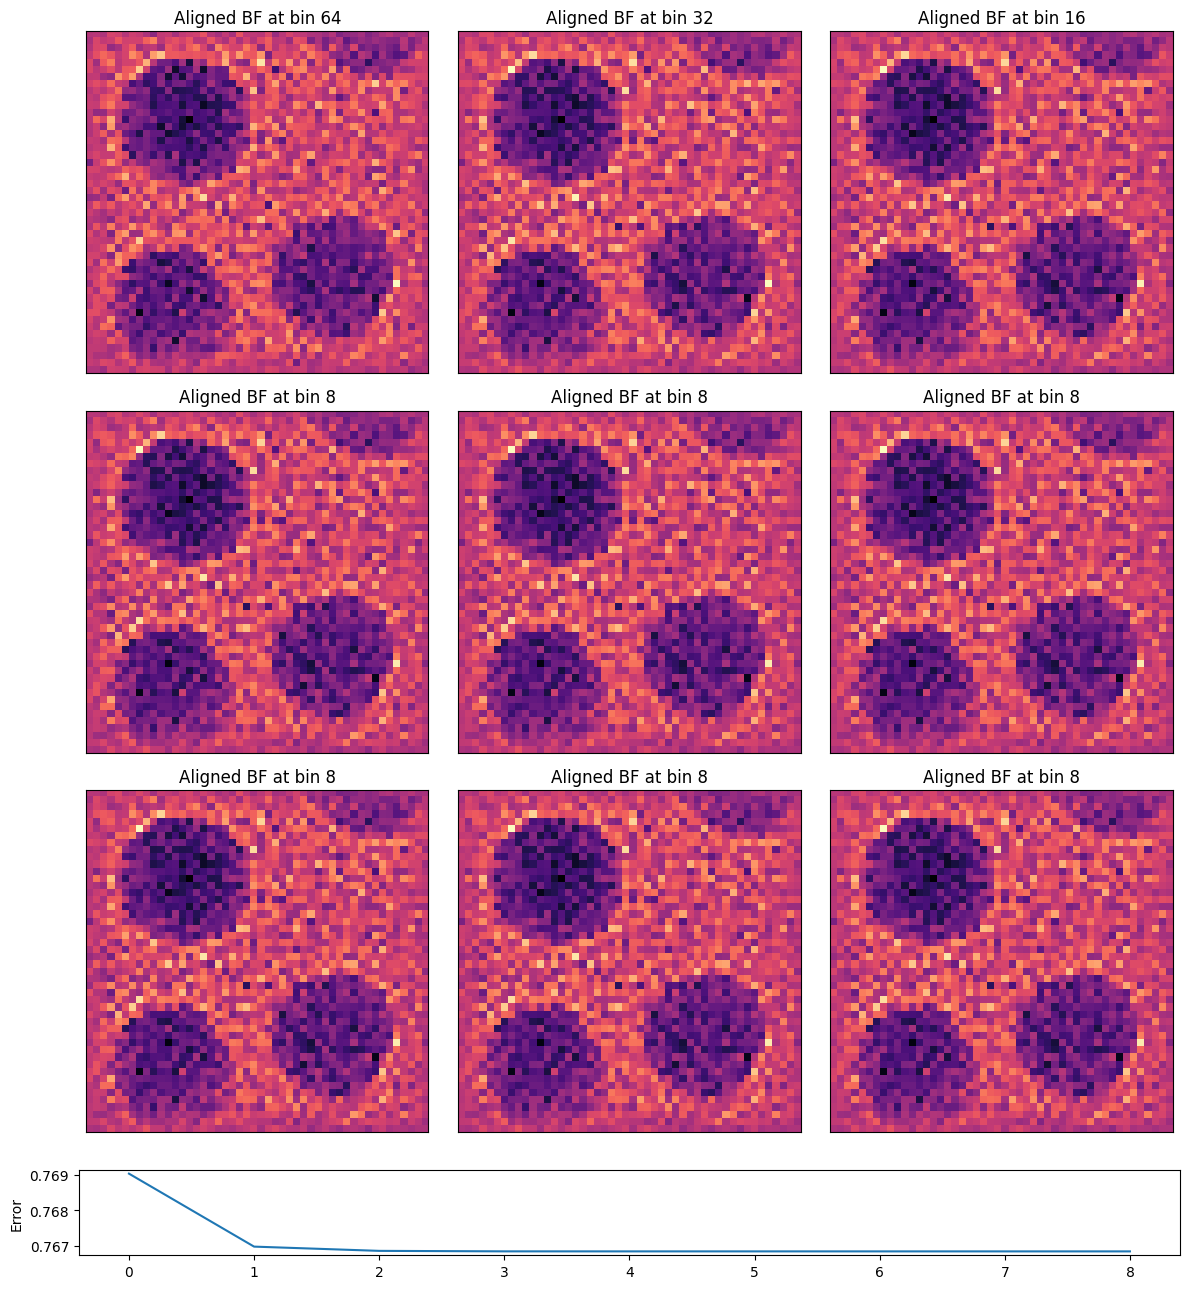

In [16]:
parallax = parallax.reconstruct(
    reset=True,
    min_alignment_bin=8,
    num_iter_at_min_bin = 6,
)

Note how much sharper the images are!  The tilt-shift parallax correction has brought the sum of all images into focus.  

We can visualize the cross-correlation shifts for each BF pixel to get a sense of the aberration surface:

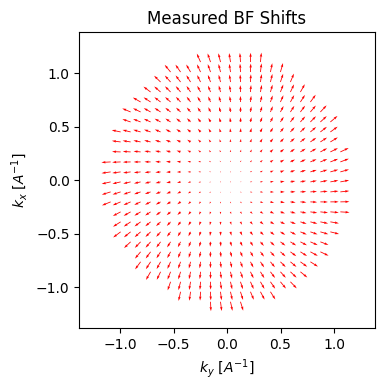

In [17]:
parallax.show_shifts(
    plot_arrow_freq=4
)

The sampling of the reconstructed images above is given by the scan step-size. However, the cross-correlation vector shifts have subpixel precision, and thus we can upsample our reconstruction and use kernel-density estimation (KDE) to align the virtual BF images.

Parallax( A Node called 'parallax_reconstruction', containing the following top-level objects in its tree:

)

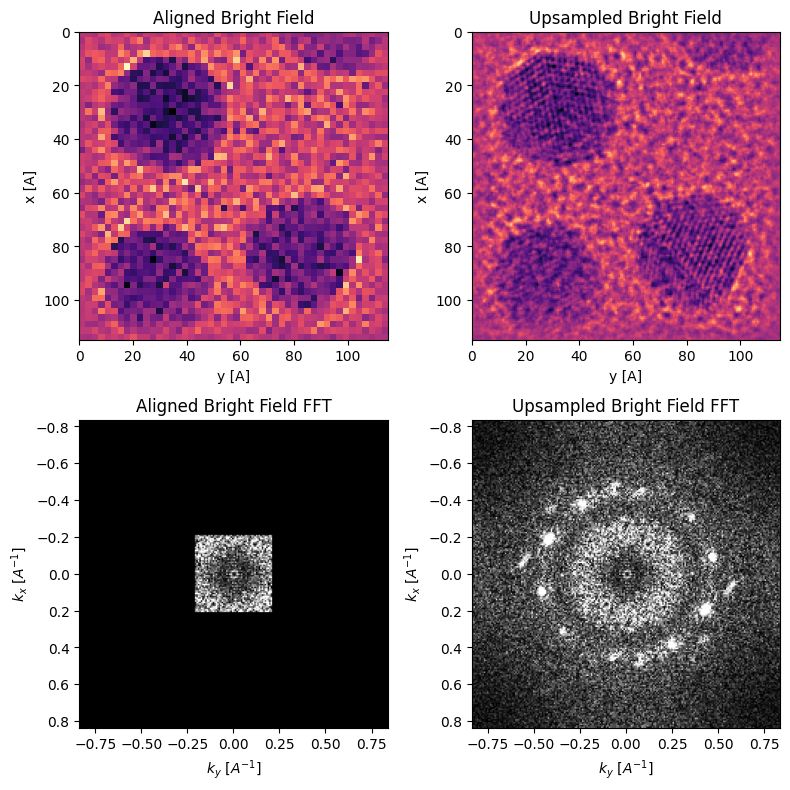

In [18]:
parallax.subpixel_alignment(
    kde_upsample_factor=4,
    plot_upsampled_BF_comparison=True,
    plot_upsampled_FFT_comparison=True,
)

Comparing the two FFTs out to the same scattering angle we can see the upsampled image has "unwrapped" the CTF and indicates Bragg peaks corresponding to atomic-spacings in Au, which are clearly visible in the aligned upsampled BF image!

The parallax reconstruction holds a great deal of information on the aberration surface, which can be estimated directly from the cross-correlation shifts and/or the FFT Thon rings. First, we can solve for low-order aberrations such as defocus, and astigmatism using a simple 2x2 affine transform of the measured cross-correlation shifts:

         Initial aberration coefficients          
--------------------------------------------------
  rotation   transpose    C1      stig  stig angle
   [deg]       ---       [Ang]   [Ang]     [deg]  
----------   -------   -------   -----   ---------
  -11.3       False      404       7       57.8   

         Refined aberration coefficients          
--------------------------------------------------
aberration    radial   angular   angle   magnitude
   name       order     order    [deg]     [Ang]  
----------   -------   -------   -----   ---------
    C1          2         0       ---       412   
   stig         2         2      62.9        9    
   coma         3         1      85.1      3724   
 trefoil        3         3      38.3       21    


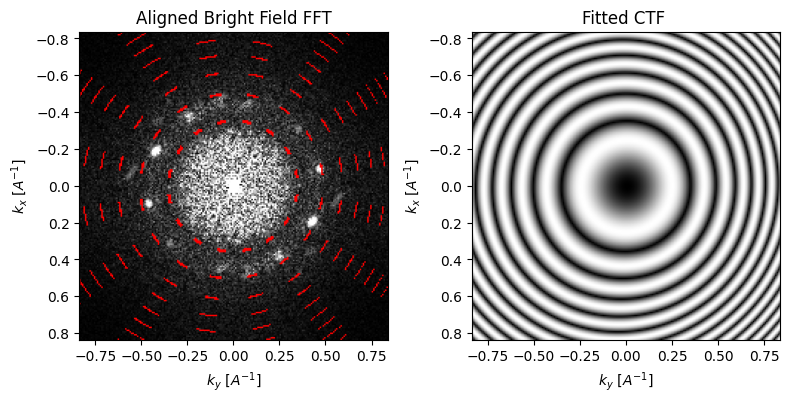

In [19]:
parallax = parallax.aberration_fit(
    plot_CTF_comparison = True,
)

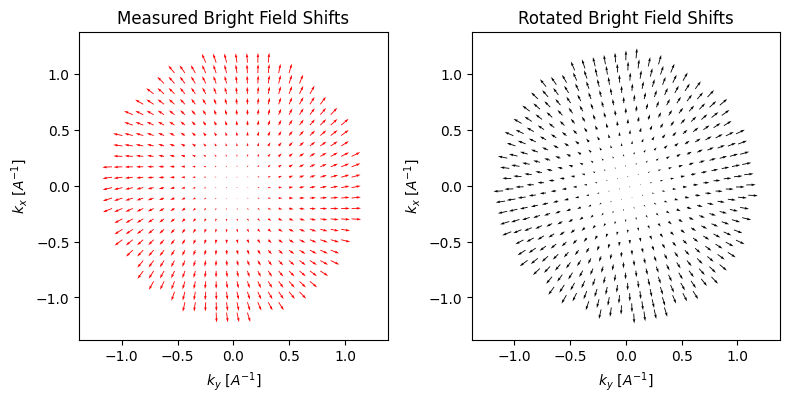

In [20]:
parallax.show_shifts(
    plot_arrow_freq=4,
)

We can use the fitted CTF to correct the subpixel-aligned BF-image:

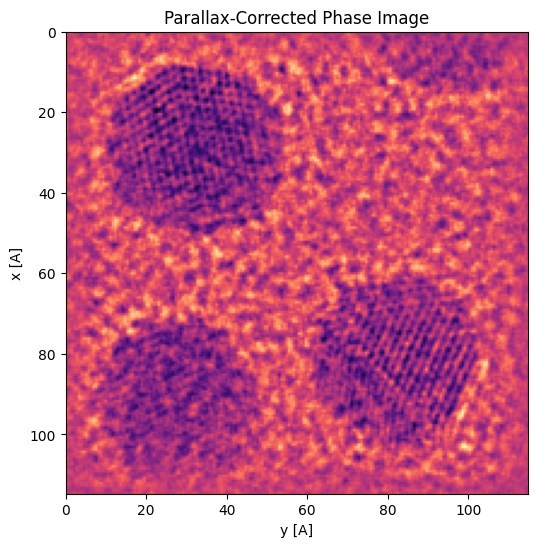

In [21]:
parallax = parallax.aberration_correct(
    # use_CTF_fit=True,
)

Again we see the phase is backwards, so we can correct this by forcing an additional 180 degree rotation in the parallax.

In [22]:
parallax = parallax.aberration_fit(
    force_rotation_deg=-11 + 180
)

         Initial aberration coefficients          
--------------------------------------------------
  rotation   transpose    C1      stig  stig angle
   [deg]       ---       [Ang]   [Ang]     [deg]  
----------   -------   -------   -----   ---------
  -11.3       False      404       7       57.8   

         Refined aberration coefficients          
--------------------------------------------------
aberration    radial   angular   angle   magnitude
   name       order     order    [deg]     [Ang]  
----------   -------   -------   -----   ---------
    C1          2         0       ---       412   
   stig         2         2      62.9        9    
   coma         3         1      85.1      3724   
 trefoil        3         3      38.3       21    


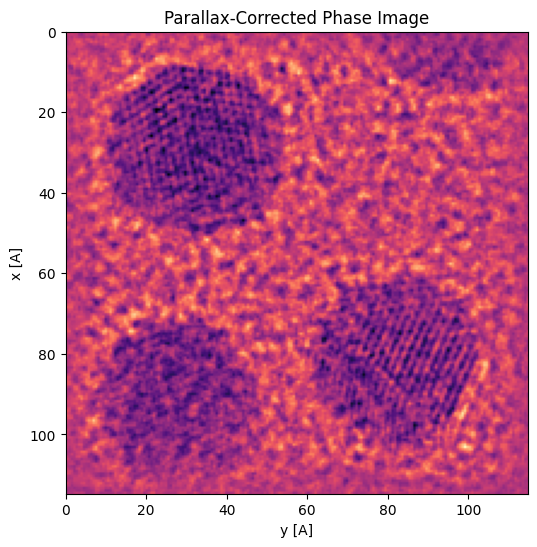

In [23]:
parallax = parallax.aberration_correct(
    use_CTF_fit=True,
)

## Ptychography

To reconstruct the complex object wave including both amplitude and phase, while simultaneously solving for the probe aberrations and deconvolving the probe, we will use ptychography. Notes

- We use the initial rotation estimate from the previous parallax measurements.
- We use the initial defocus estimate from the previous parallax measurements.

Calculating center of mass: 100%|██████████| 2304/2304 [00:01<00:00, 1707.37probe position/s]
Best fit rotation forced to -11 degrees.
Transpose of intensities forced to False.
Normalizing amplitudes: 100%|██████████| 2304/2304 [00:23<00:00, 97.08probe position/s]


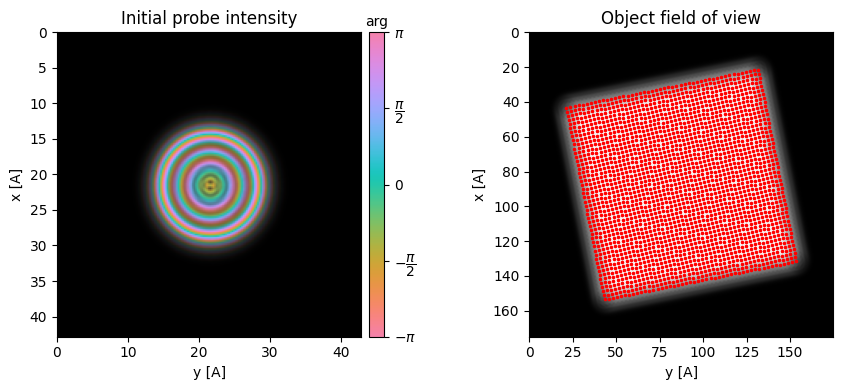

In [26]:
ptycho = py4DSTEM.process.phase.SingleslicePtychography(
    datacube = datacube,
    device = 'gpu',
    storage='cpu',
    energy = 300e3,
    vacuum_probe_intensity = probe.data,
    defocus = -parallax.aberrations_C1, # 1025
    # object_type="potential"
).preprocess(
    plot_center_of_mass = False,
    plot_rotation = False,
    plot_probe_overlaps = True,
    force_com_rotation = np.rad2deg(parallax.rotation_Q_to_R_rads),
    vectorized_com_calculation=False,
    max_batch_size=512,
    force_com_transpose = parallax.transpose, # False
)

In [ ]:
ptycho.reconstruct?

Performing 64 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1 and step_size: 0.5, in batches of max 512 measurements.
Reconstructing object and probe: 100%|██████████| 64/64 [00:32<00:00,  1.95 iter/s]


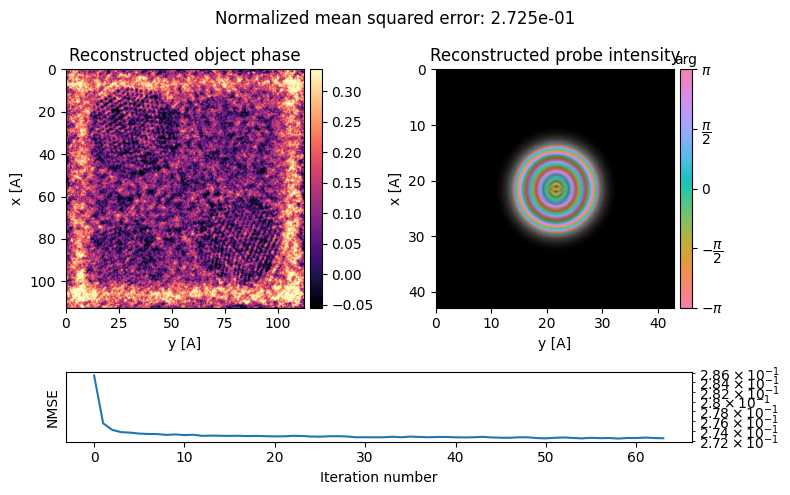

In [32]:
ptycho = ptycho.reconstruct(
    reset = True,
    store_iterations = True,
    num_iter = 64,
    step_size=0.5,
    max_batch_size=512,
    fix_probe=True,
).visualize(
)

## Comparison

We can finally compare the dpc, upsampled parallax, and ptychographic phase images:

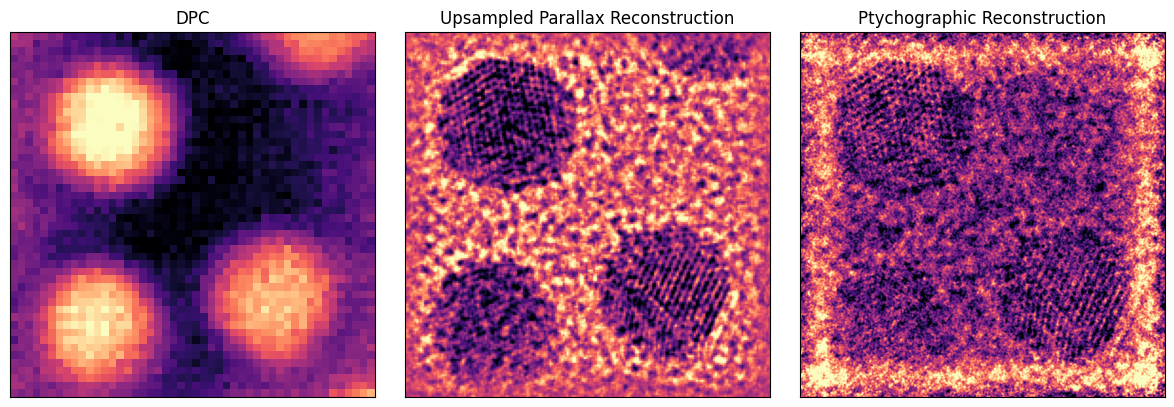

In [33]:
py4DSTEM.show(
    [
        dpc_180.object_phase,
        parallax.object_cropped,
        np.angle(ptycho.object_cropped),
    ],
    cmap = 'magma',
    ticks = False,
    axsize =(4,4),
    title = ["DPC","Upsampled Parallax Reconstruction","Ptychographic Reconstruction"],
)